In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent ## geotiff plotting
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
geotiffs=[]

for i in range(1,13):
    geotiff='Example/YearRoundNDVI/' +str(i)+ '.tif'
    shp=rio.open(geotiff)
    geotiffs.append(shp)

extent = plotting_extent(geotiffs[0])

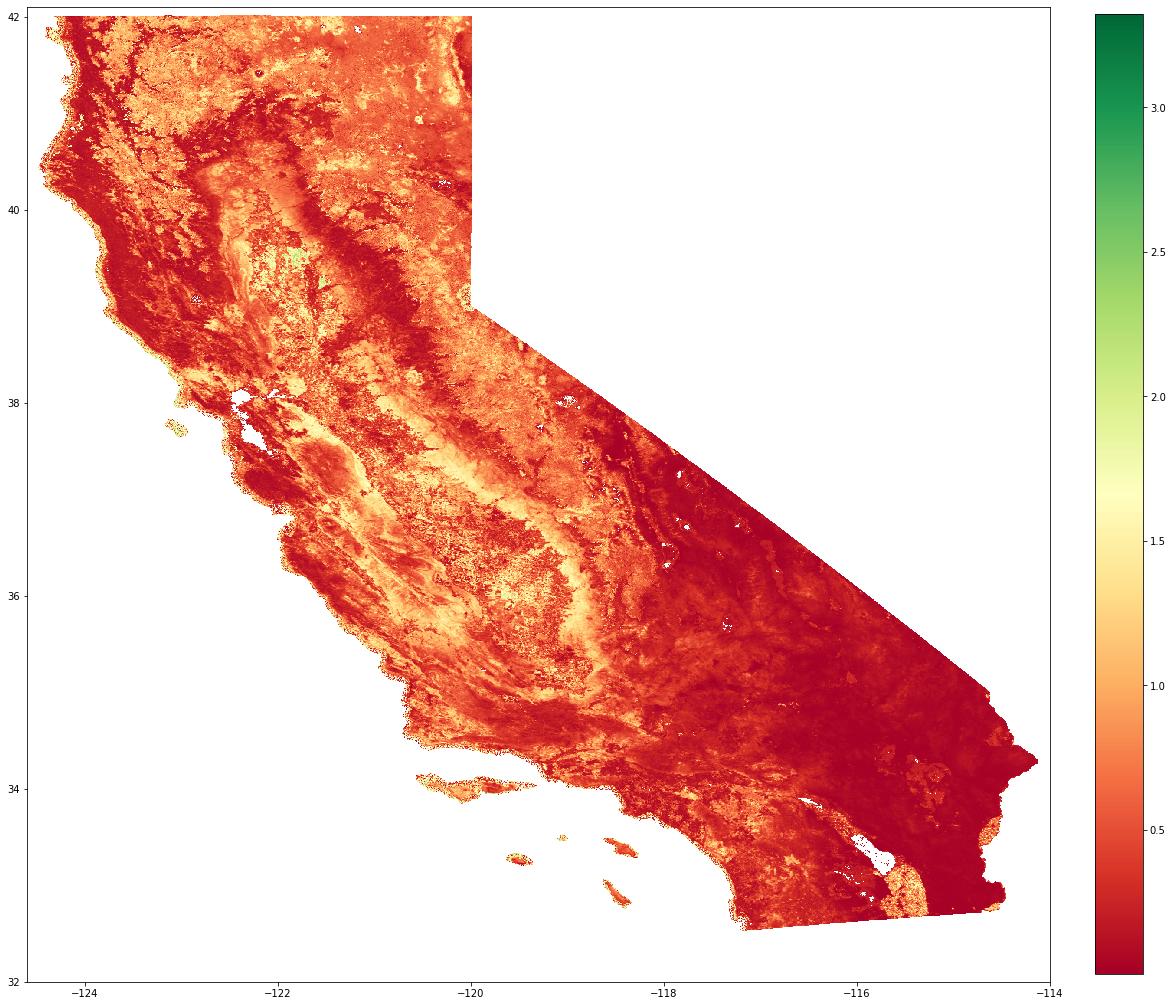

In [3]:
meanNDVI=np.mean([geotiffs[i].read(1) for i in range(12)])

stdNDVI=np.std([geotiffs[i].read(1) for i in range(12)],axis=0)

display=np.divide(stdNDVI,meanNDVI)
display[display==0]=np.nan

f,ax =plt.subplots(figsize=(20,20))
color=ax.imshow(display,cmap='RdYlGn',extent=extent)

plt.colorbar(color,ax=ax,fraction=0.043, pad=0.04)


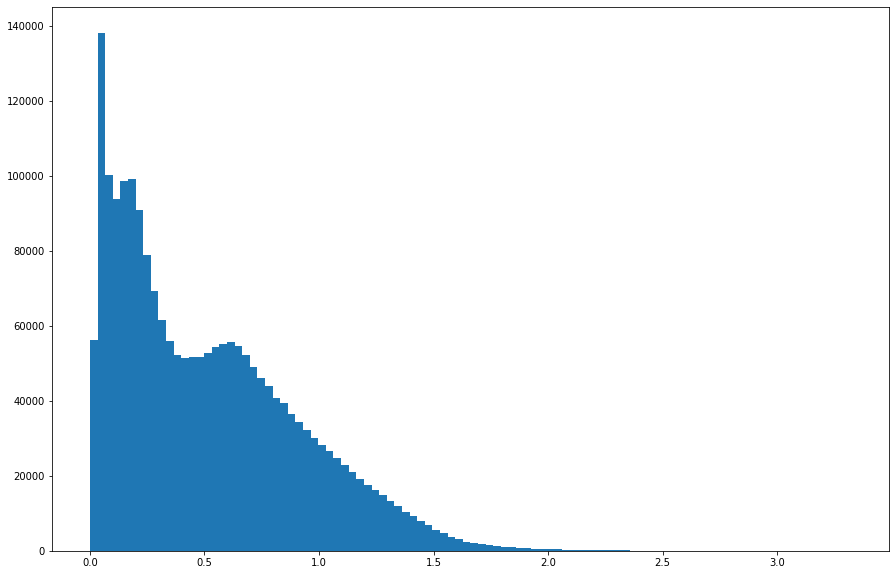

In [4]:
f,ax =plt.subplots(figsize=(15,10))
ax.hist(display[~np.isnan(display)],bins=100)
plt.show()

In [5]:
np.mean(display[~np.isnan(display)])

0.51665515

In [6]:
cities={'Name':['Los Angeles','San Diego','San Jose','San Francisco','Fresno','Sacramento',
                'Long Beach','Oakland','Bakersfield','Anaheim'],
        'Latitude' : [34.052235,32.715736,37.335480,37.733795,36.746841,38.575764,33.770050,
                    37.804363,35.393528,33.835293],
        'Longitude' : [-118.243683,-117.161087,-121.893028,-122.446747,-119.772591,-121.478851,
                       -118.193741,-122.271111,-119.043732,-117.914505]
       }

cities_df=pd.DataFrame(cities)
cities_df.index+=1
cities_df

,Name,Latitude,Longitude
1,Los Angeles,34.052235,-118.243683
2,San Diego,32.715736,-117.161087
3,San Jose,37.335480,-121.893028
4,San Francisco,37.733795,-122.446747
5,Fresno,36.746841,-119.772591
6,Sacramento,38.575764,-121.478851
7,Long Beach,33.770050,-118.193741
8,Oakland,37.804363,-122.271111
9,Bakersfield,35.393528,-119.043732
10,Anaheim,33.835293,-117.914505


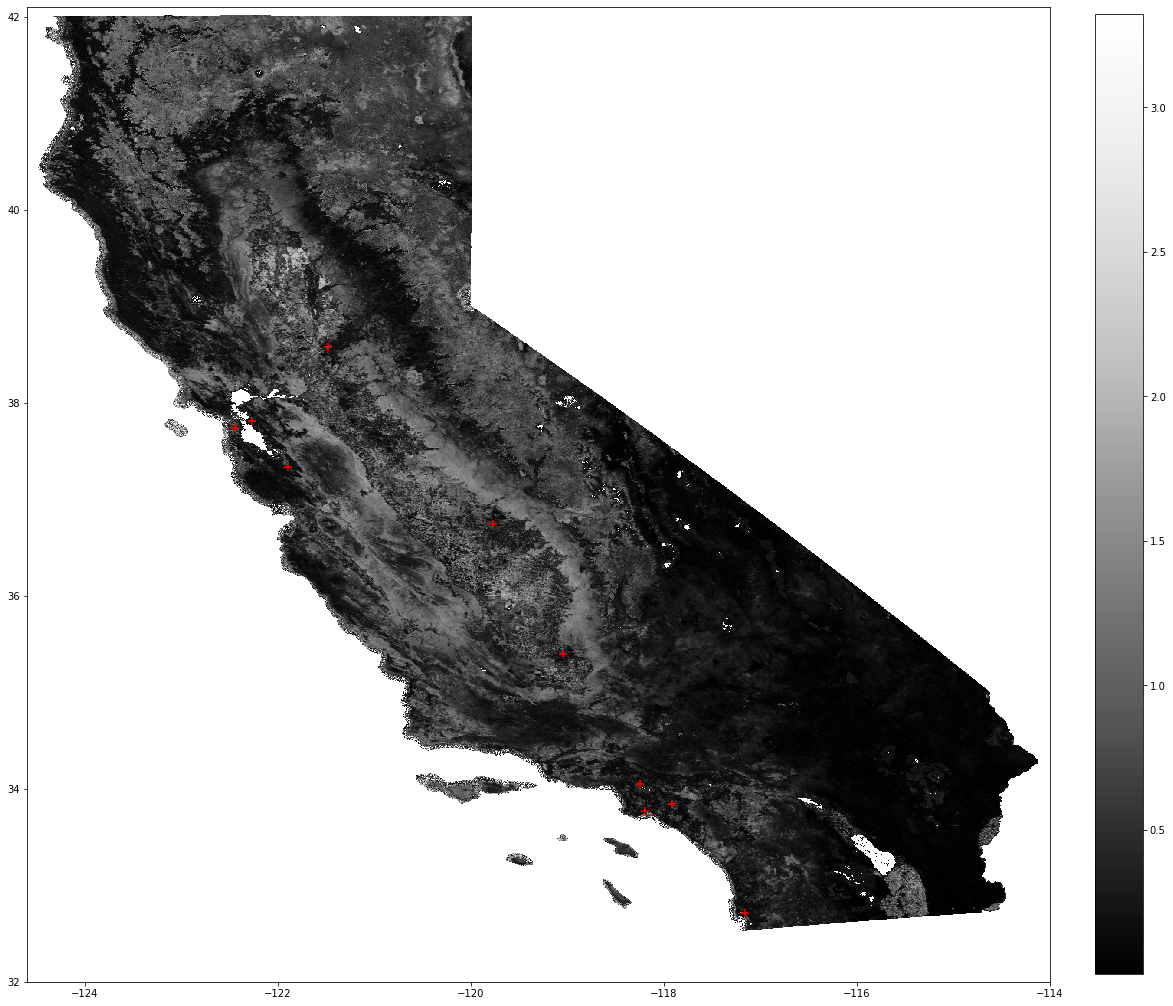

In [7]:
f,ax =plt.subplots(figsize=(20,20))
color=ax.imshow(display,cmap='Greys_r',extent=extent)
plt.colorbar(color,ax=ax,fraction=0.043, pad=0.04)
plt.scatter(cities_df['Longitude'],cities_df['Latitude'],marker='+',c='red',s=50)


In [8]:
extent

(-124.60082148379823,
 -113.99620955476728,
 31.997990420337352,
 42.10403736668197)

C:\Users\emili\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:931: RuntimeWarning: invalid value encountered in less
  scalex = (xx < xmin) or (xx > xmax)
C:\Users\emili\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:931: RuntimeWarning: invalid value encountered in greater
  scalex = (xx < xmin) or (xx > xmax)


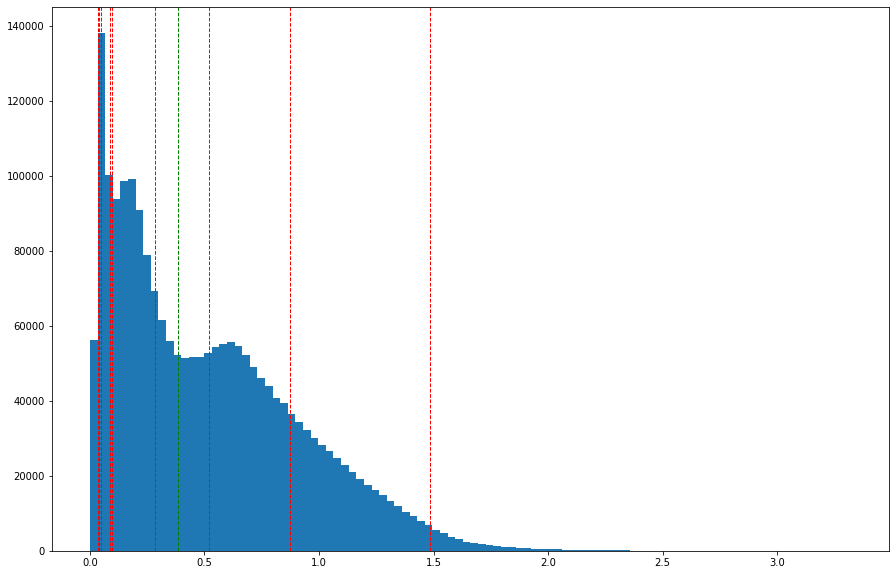

In [9]:
def lngToNp(lng):
    m=display.shape[1]/(extent[1]-extent[0])
    return 1+int(np.floor(m*lng + (0-m*extent[0])))

def latToNp(lat):
    m=display.shape[0]/(extent[3]-extent[2])
    return 1+int(np.floor(-m*lat + (display.shape[0]+m*extent[2])))
    

cities_df['NumpyLat']=cities_df['Latitude'].apply(latToNp)
cities_df['NumpyLng']=cities_df['Longitude'].apply(lngToNp)

f,ax =plt.subplots(figsize=(15,10))
ax.hist(display[~np.isnan(display)],bins=100)

NDVIcities=display[cities_df['NumpyLng'],cities_df['NumpyLat']]

for Q in NDVIcities:
    plt.axvline(Q, color='r', linestyle='dashed', linewidth=1)

meancities=np.mean(NDVIcities[~np.isnan(NDVIcities)])

plt.axvline(meancities, color='g', linestyle='dashed', linewidth=1)

plt.show()

<Figure size 432x288 with 0 Axes>

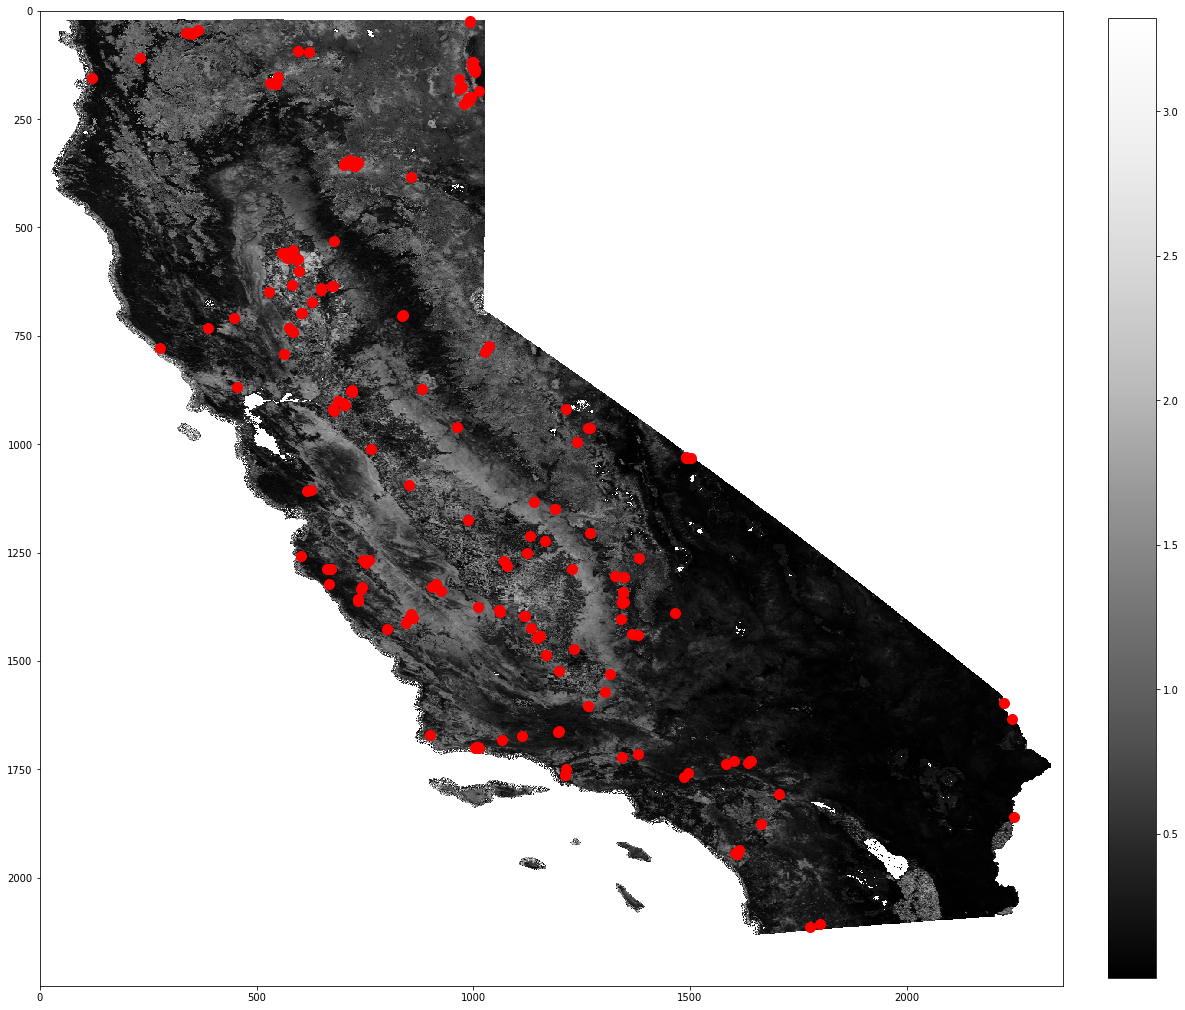

In [11]:
fire_file = 'Github/Clover/data/shapefile/ca_2.shp'
fire_shp = gpd.read_file(fire_file)
fire_shp.plot(ax=ax,cmap='Reds')

FireNumpyLoc = pd.DataFrame()
FireNumpyLoc['FireNumpyLong']=fire_shp['lon'].apply(lngToNp)
FireNumpyLoc['FireNumpyLat']=fire_shp['lat'].apply(latToNp)
FireNumpyLoc['year']=fire_shp['year']

#Just keep values in NDVI region, and year is 2016
FireNumpyLoc=FireNumpyLoc[FireNumpyLoc['year']==2016]
FireNumpyLoc=FireNumpyLoc[(FireNumpyLoc['FireNumpyLong']>=0)& (FireNumpyLoc['FireNumpyLong']<=display.shape[1])]
FireNumpyLoc=FireNumpyLoc[(FireNumpyLoc['FireNumpyLat']>=0)& (FireNumpyLoc['FireNumpyLat']<=display.shape[0])]

f,ax =plt.subplots(figsize=(20,20))
color=ax.imshow(display,cmap='Greys_r')
plt.colorbar(color,ax=ax,fraction=0.043, pad=0.04)
plt.scatter(FireNumpyLoc['FireNumpyLong'],FireNumpyLoc['FireNumpyLat'],marker='o',c='red',s=100)

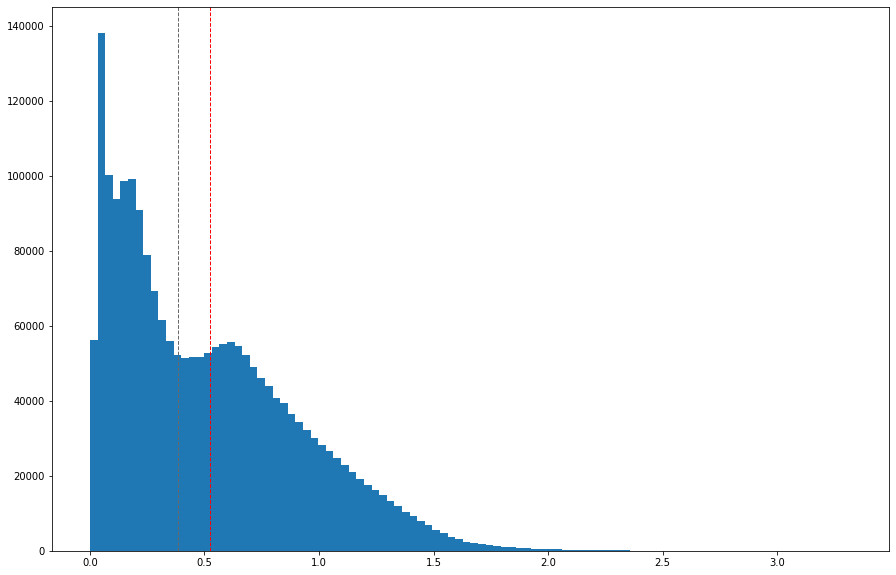

In [12]:
NDVIfires=display[FireNumpyLoc['FireNumpyLong'],FireNumpyLoc['FireNumpyLat']]

meanfires=np.mean(NDVIfires[~np.isnan(NDVIfires)])

f,ax =plt.subplots(figsize=(15,10))
ax.hist(display[~np.isnan(display)],bins=100)

plt.axvline(meancities, color='dimgray', linestyle='dashed', linewidth=1)
plt.axvline(meanfires, color='r', linestyle='dashed', linewidth=1)

